# Spatial Data Science I: Representing Spatial Data

In [1]:
import pandas as pd
import geopandas as gpd
import libpysal.api as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

Today, we'll talk about representing spatial relationships in Python using PySAL's *spatial weights* functionality. This provides a unified way to express the spatial relationships between observations. 

First, though, we'll need to read in our data for the day: Airbnb listings & nightly prices for neighbourhoods in Berlin. 

In [2]:
listings = pd.read_csv('./data/berlin-listings.csv.gz')
neighbourhoods = gpd.read_file('data/berlin-neighbourhoods.geojson').to_crs(epsg=3857)

### Converting flat text into geodata

Our airbnb data in `listings` is not actually recognized as spatial data yet, since it's only got flat text in its `longitude` and `latitude` columns. 

To get this to be "spatial" data, we need to first construct *geometries* from this information, and then wrap this table inside of a `geopandas.GeoDataFrame`, the typical/standard method of expressing spatial points, lines, or polygon data in Python. 

In [3]:
listings['geometry'] = listings[['longitude','latitude']].apply(geom.Point, 
                                                                axis=1) #take each row

In [4]:
listings = gpd.GeoDataFrame(listings)
listings.crs={'init':'epsg:4269'}
listings = listings.to_crs(epsg=3857)

### Getting basemap info

Further, we'll grab a basemap for our study area using `contextily`. Contextily is package designed to provide basemaps for data. It's best used for data in webmercator or raw WGS longitude-latitude coordinates.

Below, I'm going to grab the basemap images for the `total_bounds` of our study area at a given zoom level. Further, I'm specifying a different tile server from the default, the [Stamen Maps `toner-lite` tiles](http://maps.stamen.com/m2i/#toner-lite/1500:1000/12/47.5462/7.6196), to use since I like its aesthetics. 

In [5]:
basemap, bounds = ctx.bounds2img(*listings.total_bounds, zoom=10, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

Spatial plotting has come a long way since I first started in spatial data science. But, a few tricks for `geopandas` are still somewhat arcane, so it's useful to know them.

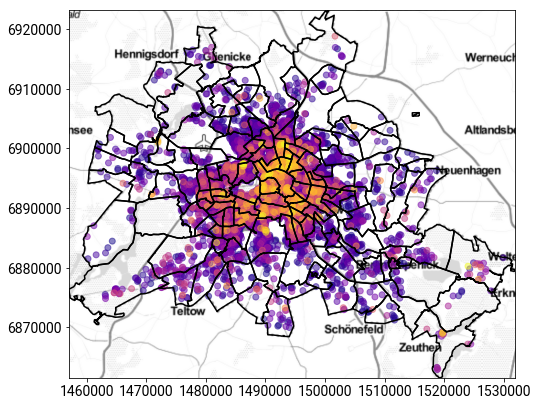

In [6]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# TRICK 1: when you only want to plot the boundaries, not the polygons themselves:
neighbourhoods.boundary.plot(color='k', ax=ax)
# TRICK 2: to keep the tiles aligned with your map's extent, use the "extent" argument in imshow. 
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
# TRICK 3: Sorting the data before plotting it will ensure that 
#          the highest (or lowest) categories are prioritized in the plot.
#          Use this to mimick blending or control the order in which alpha blending might occur. 
listings.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)

# Spatial Weights: expressing spatial relationships mathematically

Spatial weights matrices are mathematical objects that are designed to express the inter-relationships between sites in a given geolocated frame of analysis. 

This means that the relationships between each site (of which there are usually $N$) to every other site is *represented* by the weights matrix, which is some $N \times N$ matrix of "weights," which are scalar numerical representations of these relationships.
In a similar fashion to *affinity matrices* in machine learning, spatial weights matrices are used in a wide variety of problems and models in quantitative geography and spatial data science to express the spatial relationships present in our data. 

In python, PySAL's `W` class is the main method by which people construct & represent spatial weights. This means that arbitary inter-site linkages can be expressed using one dictionary, and another *optional* dictionary: 

- **a `neighbors` dictionary,** which encodes a *focal observation*'s "name" and which other "named" observations the focal is linked.
- **a `weights` dictionary,** which encodes how strongly each of the neighbors are linked to the focal observation. 

Usually, these are one-to-many mappings, dictionaries keyed with the "focal" observation and values which are lists of the names to which the key is attached.

An example below shows three observations, `a`,`b`, and `c`, arranged in a straight line:

In [7]:
neighbors = dict(a = ['b'],
                 b = ['a','c'],
                 c = ['b']
                 )

Connectivity strength is recorded in a separate dictionary whose keys should align with the `neighbors`:

In [8]:
weights = dict(a = [1],
               b = [.2, .8],
               c = [.3]
                )

To construct the most generic spatial weights object, only the `neighbors` dictionary is required; the `weights` will assumed to be one everywhere. 

In [9]:
binary = lp.W(neighbors) # assumes all weights are one

In [10]:
binary.weights

{'a': [1.0], 'b': [1.0, 1.0], 'c': [1.0]}

In [11]:
weighted = lp.W(neighbors, weights=weights)

In [12]:
weighted.weights

{'a': [1], 'b': [0.2, 0.8], 'c': [0.3]}

# Constructing different types of weights

By itself, this is not really useful; the hardest part of *using* these representations is constructing them from your original spatial data. Thus, I show below how this can be done. First, I cover *contiguity* weights, which are analogues to adjacency matrices . These are nearly always used for polygonal "lattice" data, but can also be used for points as well by examining their voronoi diagram. 

Second, I cover *distance* weights, which usually pertain to point data only. These tend to embed notions of distance decay, and are incredibly flexible for multiple forms of spatial data. 

# Contiguity


Contiguity weights, or "adjacency matrices," are one common representation of spatial relationships that spring to mind when modeling how polygons relate to one another. In this representation, objects are considered "near" when they touch, and "far" when they don't. adjacency is considered as a "binary" relationship, so all polygons that are near to one another are *as near as they are to any other near polygon*. 

We've got fast algos to build these kinds of relationships from `shapely`/`geopandas`, as well as directly from files (without having to read all the data in at once). 

In [13]:
Qneighbs = lp.Queen.from_dataframe(neighbourhoods)

The `pysal` library is currently going under a bit of restructuring. 

But, the main components of the package are migrated to `libpysal`, which forms the base of a constellation of spatial data science packages. 

We'll focus on `libpysal` throughout the analysis; all of this functionality should be offered directly in `pysal` by the end of 2018. 

Given this, we you can plot the adjacency graph for the polygons we showed above as another layer in the plot. I'll remove some of the view to make the view simpler to examine:

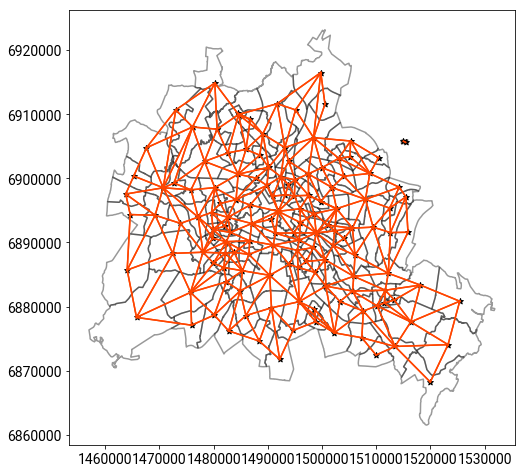

In [14]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
neighbourhoods.boundary.plot(color='k', ax=ax, alpha=.4)
#basemap of the area
#ax.imshow(basemap, extent=bounds, interpolation='gaussian')
#ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
#if you want the highest values to show on top of lower ones
#listings.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)
Qneighbs.plot(neighbourhoods, edge_kws=dict(linewidth=1.5, color='orangered'), node_kws=dict(marker='*'), ax=ax)
plt.show()

Often, having observations (or components) that are disconnected can make analyses poorly behaved. It looks like there may be some disconnected observations in our data, up in northeast Berlin.

We can check if individual observations are disconnected using the weights object's `islands` argument:

In [15]:
Qneighbs.islands

[]

There are no single observations that are disconnected, so it's probably more than one observation up in the northeast that are *disconnected from the rest of the graph*. 

Let's look at this using `scipy`.

PySAL weights can be used in other packages by converting them into their equivalent matrix representations. Sparse and dense array versions are offered, with `.sparse` providing the sparse matrix representation, and `.full()` providing the ids and dense matrix representing the graphs. 

In [16]:
spqneighbs = Qneighbs.sparse
spqneighbs.eliminate_zeros()

Visualizing the matrix, you can see that the adjacency matrix is very sparse indeed:

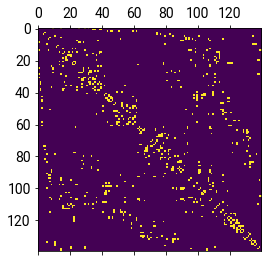

In [17]:
plt.matshow(spqneighbs.toarray())

We can get the number of links as a percentage of all possible $N^2$ links from:

In [18]:
Qneighbs.pct_nonzero

3.938775510204082

Which means that there are around 4% of all the possible connections between any two observations actually make it into the adjacency graph.

For contiguity matrices, this only has binary elements, recording 1 where two observations are linked. Everywhere else, the array is empty (zero, in a dense representation). 

In [19]:
np.unique(spqneighbs.data)

array([1.])

Fortunately for us, PySAL plays real well with scipy & other things built on top of SciPy. So, the [new compressed sparse graph (`csgraph`)](https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html) module in SciPy works wonders with the PySAL sparse weights representations. So, we often will jump back and forth between PySAL weights and scipy tools when working with these spatial representations of data. 

In [20]:
import scipy.sparse.csgraph as csgraph

Now, in `csgraph`, there are a ton of tools to work with graphs. For our purposes, if we just wanted to keep the big connected graph and drop the secondary small disconnected graph, we could use `csgraph.connected_components`:

In [21]:
number_connected, labels = csgraph.connected_components(spqneighbs)

And verify that there's only the two subgraphs that we see that are disconnected:

In [22]:
print(number_connected, labels)

2 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Yep! there are two components, one with two elements and another with all the rest. 

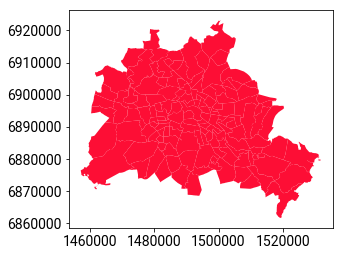

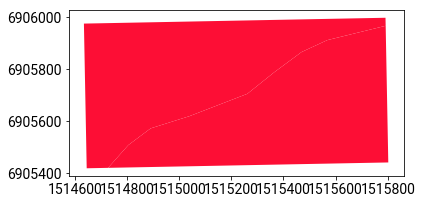

In [23]:
for label in range(0,2):
    neighbourhoods[labels == label].plot()
    plt.show()

So, this might be a digitzation error, or may be something else. 

Regardless, it's common to only want to focus on the connected parts at one time; to get there, we'll subset the dataframe and rebuild the weights:

In [24]:
neighbourhoods = neighbourhoods[labels==0]
neighbourhoods = neighbourhoods.reset_index(drop=True) #

Now, we can rebuild our weights:

In [25]:
Qconnected = lp.Queen.from_dataframe(neighbourhoods)

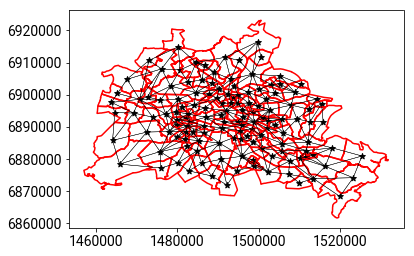

In [26]:
Qconnected.plot(neighbourhoods, node_kws=dict(marker='*'), edge_kws=dict(linewidth=.4))
neighbourhoods.boundary.plot(color='r', ax=plt.gca())

In addition, we could use the `lp.w_subset` function, which would avoid re-constructing the weights again. This might help if they are truly massive, but it's often just as expensive to discover the subset as it is to construct a new weights object from this subset. 

In [27]:
Qconnected2 = lp.w_subset(Qneighbs, ids=[i for i in range(Qneighbs.n) if labels[i] == 0])

Sometimes, if `pandas` rearranges the dataframes, these will appear to be different weights since the ordering is different. To check if two weights objects are identical, a simple test is to check the sparse matrices for **in**equality:

In [28]:
(Qconnected2.sparse != Qconnected.sparse).sum()

0

### Alternative Representations

PySAL, by default, tends to focus on a single `W` object, which provides easy tools to construct & work with the accompanying sparse matrix representations. 

However, it's often the case we want alternative representations of the same relationships. 

One handy one is the weights list. This is an alternative form of expressing a weights matrix, and provides a copy of the underlying `W.sparse.data`, made more regular and put into a pandas dataframe.  

In [29]:
adjlist = Qconnected.to_adjlist()
adjlist.head()

,focal,neighbor,weight
0,0,23,1.0
1,0,9,1.0
2,0,27,1.0
3,0,12,1.0
4,0,29,1.0


This handy if you'd rather work with the representation in terms of individual edges, rather than in sets of edges. 

Also, it is exceptionally handy when you want to ask questions about the data used to generate the spatial weights, since it lets you attach this data to each of the focal pairs and ask questions about the associated data at that level. 

For example, say we get the median price of airbnbs within a given neighbourhood:

In [30]:
hoodprice = listings.groupby("neighbourhood_cleansed").price.median().to_frame()

In [31]:
hoodprice.head()

,price
neighbourhood_cleansed,
Adlershof,37.0
Albrechtstr.,35.0
Alexanderplatz,65.0
Allende-Viertel,21.0
Alt Treptow,43.5


Now, I'm going to attach that back to the dataframe containing the neighbourhood information. 

In [32]:
neighbourhoods = neighbourhoods.merge(
                           hoodprice,
                           left_on='neighbourhood', right_index=True, how='left')

In [33]:
neighbourhoods = neighbourhoods.rename(columns=dict(price='median_price'))

Then, we can map this information at the neighbourhood level, computed from the individual listings within each neighbourhood:

/home/lw17329/anaconda/envs/gds/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


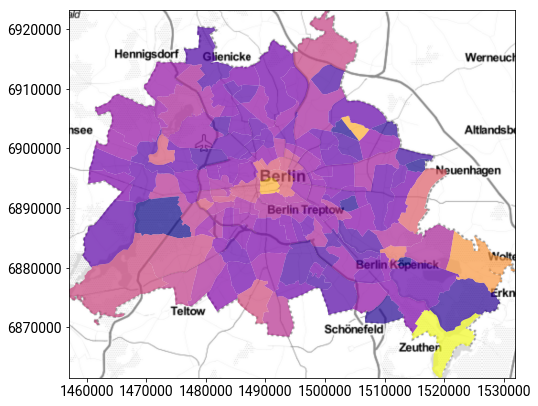

In [34]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
neighbourhoods.plot('median_price', cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
#if you want the highest values to show on top of lower ones
plt.show()

Then, to examine the local relationships in price between nearby places, we could merge this information back up with the weights list and get the difference in price between every adjacent neighbourhood. 

Usually, these joins involve building links between both the focal and neighbor observation IDs. You can do this simply by piping together two merges: one that focuses on the "focal" index and one that focuses on the "neighbor" index.

Using a suffix in the later merge will give the data joined on the focal index a distinct name from that joined on the neighbor index. 

In [35]:
adjlist = adjlist.merge(neighbourhoods[['neighbourhood', 
                                        'median_price']], 
                        left_on='focal', right_index=True, how='left')\
                  .merge(neighbourhoods[['neighbourhood', 
                                         'median_price']], 
                         left_on='neighbor', right_index=True ,how='left', 
                         suffixes=('_focal', '_neighbor'))

Then, we can group by the `focal` index and take the difference of the prices. 

In [36]:
pricediff = adjlist[['median_price_focal', 
                     'median_price_neighbor']].diff(axis=1)

In [37]:
pricediff.head()

,median_price_focal,median_price_neighbor
0,NaN,1.5
1,NaN,20.0
2,NaN,7.5
3,NaN,2.0
4,NaN,7.5


We can link this back up to the original adjacency list, but first let's rename the column we want to `price_difference` and only keep that column:

In [38]:
pricediff['price_difference'] = pricediff[['median_price_neighbor']]
adjlist['price_difference'] = pricediff[['price_difference']]

And, if we wanted to find the pair of adjacent neighbourhoods with the greatest price difference:

In [39]:
adjlist.head()

,focal,neighbor,weight,neighbourhood_focal,median_price_focal,neighbourhood_neighbor,median_price_neighbor,price_difference
0,0,23,1.0,Blankenfelde/Niederschönhausen,37.5,Buchholz,39.0,1.5
1,0,9,1.0,Blankenfelde/Niederschönhausen,37.5,Buch,57.5,20.0
2,0,27,1.0,Blankenfelde/Niederschönhausen,37.5,Schönholz/Wilhelmsruh/Rosenthal,45.0,7.5
3,0,12,1.0,Blankenfelde/Niederschönhausen,37.5,Nord 2,39.5,2.0
4,0,29,1.0,Blankenfelde/Niederschönhausen,37.5,Pankow Zentrum,45.0,7.5


Now, we can group by *both* the focal and neighbor name to get a meaningful list of all the neighborhood boundaries & their difference in median listing price. 

In [40]:
contrasts = adjlist.groupby(("neighbourhood_focal", 
                 "neighbourhood_neighbor")).price_difference\
                .median().abs().sort_values().to_frame().reset_index()

For about twenty neighbourhood pairs (since these will be duplicate `(A,B) & (B,A)` links), the median listing price is the same:

In [41]:
contrasts.query('price_difference == 0').sort_values(['neighbourhood_focal','neighbourhood_neighbor'])

,neighbourhood_focal,neighbourhood_neighbor,price_difference
9,Alt-Hohenschönhausen Süd,Weißensee Ost,0.0
24,Baumschulenweg,Britz,0.0
20,Baumschulenweg,Oberschöneweide,0.0
8,Britz,Baumschulenweg,0.0
33,Düsseldorfer Straße,Neue Kantstraße,0.0
34,Falkenhagener Feld,Hakenfelde,0.0
23,Frankfurter Allee Süd,Friedrichsfelde Nord,0.0
0,Frankfurter Allee Süd FK,Karl-Marx-Allee-Süd,0.0
3,Friedrichsfelde Nord,Frankfurter Allee Süd,0.0
11,Friedrichshagen,Köpenick-Nord,0.0


On the other end, the 20 largest paired differences in median price between adjacent neighbourhoods is shown below:

In [42]:
contrasts.sort_values(['price_difference',
                       'neighbourhood_focal'],
                       ascending=[False,True]).head(40)

,neighbourhood_focal,neighbourhood_neighbor,price_difference
757,Müggelheim,Schmöckwitz/Karolinenhof/Rauchfangswerder,74.0
756,Schmöckwitz/Karolinenhof/Rauchfangswerder,Müggelheim,74.0
754,Neu-Hohenschönhausen Nord,Neu-Hohenschönhausen Süd,62.5
755,Neu-Hohenschönhausen Süd,Neu-Hohenschönhausen Nord,62.5
753,Grünau,Schmöckwitz/Karolinenhof/Rauchfangswerder,59.0
752,Schmöckwitz/Karolinenhof/Rauchfangswerder,Grünau,59.0
751,Müggelheim,Rahnsdorf/Hessenwinkel,55.0
750,Rahnsdorf/Hessenwinkel,Müggelheim,55.0
748,"Malchow, Wartenberg und Falkenberg",Neu-Hohenschönhausen Nord,50.0
749,Neu-Hohenschönhausen Nord,"Malchow, Wartenberg und Falkenberg",50.0


## Contiguity for points

Contiguity can also make sense for point objects as well, if you think about the corresponding Voronoi Diagram and the Thiessen Polygons's adjacency graph. 

Effectively, this connects each point to a set of its nearest neighbouring points, without pre-specifying the number of points.

We can use it to define relationships between airbnb listings in our dataset. 

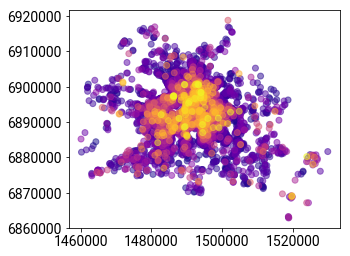

In [43]:
listings.sort_values('price').plot('price', cmap='plasma', alpha=.5)

In [44]:
from libpysal.weights.user import voronoiW,voronoi_frames

In [45]:
coordinates = np.vstack((listings.centroid.x, listings.centroid.y)).T

In [46]:
thiessens, points = voronoi_frames(coordinates)

However, the "natural" polygons generated by the `scipy.distance.voronoi` object may be excessively big, since some of the nearly-parallel lines in the voronoi diagram may take a long time to intersect. 

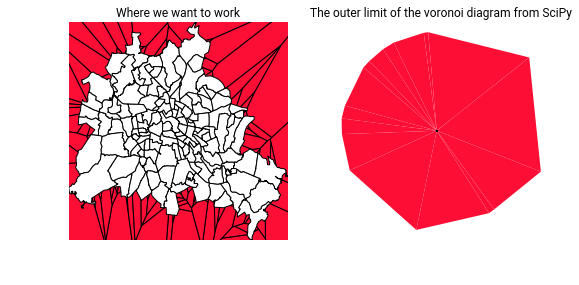

In [47]:
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
thiessens.plot(ax=ax[0], edgecolor='k')
neighbourhoods.plot(ax=ax[0], color='w', edgecolor='k')
ax[0].axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Where we want to work")
thiessens.plot(ax=ax[1])
neighbourhoods.plot(ax=ax[1], color='w', edgecolor='k')
ax[1].set_title("The outer limit of the voronoi diagram from SciPy")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Fortunately, PySAL can work with this amount of observations to build weights really quickly. But, the `geopandas` overlay operation is very slow for this many polygons, so even with a spatial index, clipping these polygons to the bounding box can take a bit...

In [48]:
thiessens.shape

(20053, 1)

So, I've precomputed the clipped version of the thiessen polygons and stored them, so that we can move forward without waiting too long

In [49]:
clipped_thiessens = gpd.read_file('./data/thiessens.shp')

Note that, whereas the overlay operation to clean up this diagram took quite a bit of computation time if just called regularly ([and there may be plenty faster ways to do these kinds of ops](http://2018.geopython.net/#w4)), constructing the topology for all 20k Thiessen polygons is rather fast:

Just to show what this looks like, I'll plot a part of one of the neighbourhoods in Berlin: the north side of Prenzlauer Berg.

In [50]:
pberg = thiessens[listings.neighbourhood_cleansed == 'Prenzlauer Berg Nord']
pberg = pberg.reset_index()

Here, I'm going to use a `Rook` contiguity criterion, which means that touching at a single point is not sufficient to consider two thiessen polygons as "neighboring."

In [51]:
Rthiessens_pberg = lp.Rook.from_dataframe(pberg)

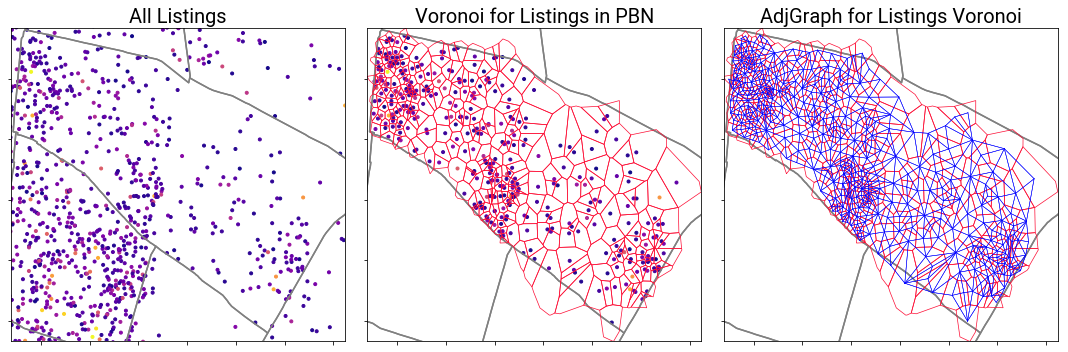

In [52]:
f,ax = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

# plot the airbnbs across the map

listings.plot('price', cmap='plasma', ax=ax[0],zorder=0, marker='.')
# Focus on pberg
ax[0].set_xlim(*pberg.total_bounds[np.asarray([0,2])])
ax[0].set_ylim(*pberg.total_bounds[np.asarray([1,3])])

# Plot the thiessens corresponding to each listing in pberg north
listings[listings.neighbourhood_cleansed == 'Prenzlauer Berg Nord']\
        .plot('price', cmap='plasma', marker='.', ax=ax[1], zorder=0)
pberg.boundary.plot(ax=ax[1], linewidth=.7)
    
# plot the thiessens and their representative network linking each airbnb
Rthiessens_pberg.plot(pberg, node_kws=dict(marker='.',s=0), 
                      edge_kws=dict(linewidth=.5), color='b', ax=ax[2])
pberg.boundary.plot(ax=ax[2], linewidth=.7)

# underlay the neighbourhood boundaries
for ax_ in ax:
    neighbourhoods.boundary.plot(ax=ax_, color='grey',zorder=1)
    ax_.set_xticklabels([])
    ax_.set_yticklabels([])
ax[0].set_title("All Listings", fontsize=20)
ax[1].set_title("Voronoi for Listings in PBN", fontsize=20)
ax[2].set_title("AdjGraph for Listings Voronoi", fontsize=20)
f.tight_layout()
plt.show()

# Distance

Distance weights tend to reflect relationships that work based on distance decay. Often, people think of spatial kernel functions when talking about distance weighting. But, PySAL also recognizes/uses distance-banded weights, which consider any neighbor within a given distance threshold as "near," and K-nearest neighbor weights, which consider any of the $k$-closest points to each point as "near" to that point. 

KNN weights, by default, are the only asymmetric weight PySAL will construct. However, using `csgraph`, one could prune/trim any of the contiguity or distance weights to be directed. 

### Kernel weights

These weights are one of the most commonly-used kinds of distance weights. They reflect the case where similarity/spatial proximity is assumed or expected to decay with distance.

Many of these are quite a bit more heavy to compute than the contiguity graph discussed above, since the contiguity graph structure embeds simple assumptions about how shapes relate in space that kernel functions cannot assume. 

Thus, I'll subset the data to a specific area of Berlin before proceeding. 

In [53]:
pkow_listings = listings[listings.neighbourhood_cleansed.str.startswith("Pankow")].reset_index()

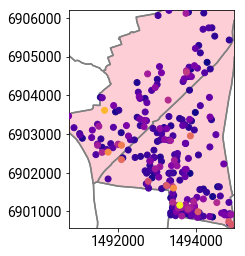

In [54]:
pkow_listings.sort_values('price').plot('price', cmap='plasma', zorder=3)
neighbourhoods.boundary.plot(color='grey', ax=plt.gca())
neighbourhoods[neighbourhoods.neighbourhood.str.startswith('Pankow')].plot(ax=plt.gca(), zorder=-1, alpha=.2)
plt.axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
plt.show()

In [55]:
Wkernel = lp.Kernel.from_dataframe(pkow_listings)

Now, if you wanted to see what these look like on the map:

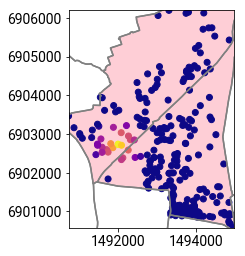

In [56]:
pkow_listings.assign(weights=Wkernel.sparse[0,:].toarray().flatten()).plot('weights', cmap='plasma')
neighbourhoods.boundary.plot(color='grey', ax=plt.gca())
neighbourhoods[neighbourhoods.neighbourhood.str.startswith('Pankow')].plot(ax=plt.gca(), zorder=-1, alpha=.2)
plt.axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
plt.show()

So, clearly, near things are weighted very highly, and distant things are weighted low. 

So, if you're savvy with this, you may wonder:
> Why use PySAL kernel weights when `sklearn.pairwise.kernel_metrics` are so much faster?

Well, PySAL's got a few enhancements over and above scikit kernel functions. 
1. **pre-specified bandwidths**: using the `bandwidth=` argument, you can give a specific bandwidth value for the kernel weight. This lets you use them in optimization routines where bandwidth might need to be a parameter that's optimized by another function.
2. **fixed vs. adaptive bandwidths**: adaptive bandwidths adjust the map distanace to make things more "local" in densely-populated areas of the map and less "local" in sparsely-populated areas. This is adjusted by the...
3. **`k`-nearest neighborhood tuning**: this argument adjusts the number of nearby observations to use for the bandwidth. 

Also, many of the scikit kernel functions are also implemented. The default is the `triangular` weight, which is a linear decay with distance.

For example, an adaptive Triangular kernel and an adaptive Gaussian kernel are shown below, alongisde the same point above for comparison. 

In [57]:
Wkernel_adaptive = lp.Kernel.from_dataframe(pkow_listings, k=200, fixed=False)

In [58]:
Wkernel_adaptive_gaussian = lp.Kernel.from_dataframe(pkow_listings, k=100, fixed=False, function='gaussian')

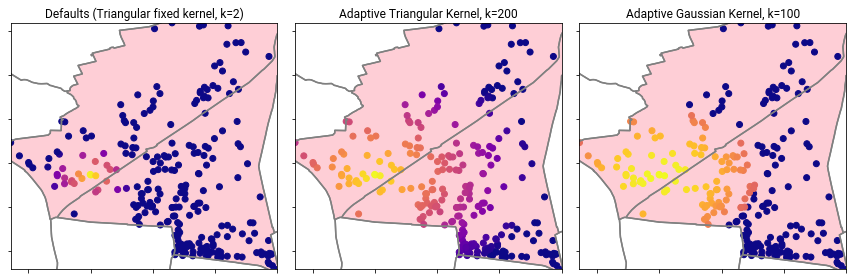

In [59]:
f,ax = plt.subplots(1,3,figsize=(12,4))
pkow_listings.assign(weights=Wkernel.sparse[0,:].toarray().flatten()).plot('weights', cmap='plasma',ax=ax[0])
pkow_listings.assign(weights=Wkernel_adaptive.sparse[0,:].toarray().flatten()).plot('weights', cmap='plasma',ax=ax[1])
pkow_listings.assign(weights=Wkernel_adaptive_gaussian.sparse[0,:].toarray().flatten()).plot('weights', cmap='plasma',ax=ax[2])
for i in range(3):
    neighbourhoods.boundary.plot(color='grey', ax=ax[i])
    neighbourhoods[neighbourhoods.neighbourhood.str.startswith('Pankow')].plot(ax=ax[i], zorder=-1, alpha=.2)
    ax[i].axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
ax[0].set_title("Defaults (Triangular fixed kernel, k=2)")
ax[1].set_title("Adaptive Triangular Kernel, k=200")
ax[2].set_title("Adaptive Gaussian Kernel, k=100")
f.tight_layout()
plt.show()

In the adaptive kernels, you also obtain a distinct bandwidth at each site:

In [60]:
Wkernel_adaptive.bandwidth[0:5]

array([[2606.42791491],
       [2692.04708088],
       [3491.70850226],
       [3256.68380896],
       [3240.96535747]])

These are useful in their own right, since they communicate information about the structure of the density of points in the analysis frame:

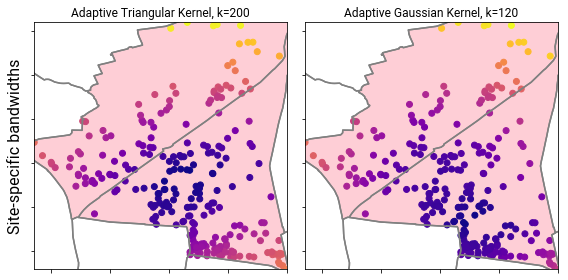

In [61]:
f,ax = plt.subplots(1,2,figsize=(8,4))
pkow_listings.assign(bandwidths=Wkernel_adaptive.bandwidth).plot('bandwidths', cmap='plasma',ax=ax[0])
pkow_listings.assign(bandwidths=Wkernel_adaptive_gaussian.bandwidth).plot('bandwidths', cmap='plasma',ax=ax[1])
for i in range(2):
    neighbourhoods.boundary.plot(color='grey', ax=ax[i])
    neighbourhoods[neighbourhoods.neighbourhood.str.startswith('Pankow')].plot(ax=ax[i], zorder=-1, alpha=.2)
    ax[i].axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
ax[0].set_title("Adaptive Triangular Kernel, k=200")
ax[0].set_ylabel("Site-specific bandwidths", fontsize=16)
ax[1].set_title("Adaptive Gaussian Kernel, k=120")
f.tight_layout()
plt.show()

Areas with large adaptive kernel bandwidths are considered in "sparse" regions and areas with small adaptive bandwidths are in "dense" regions; a similar kind of logic is used by clustering algortihms descended from DBSCAN. 

### Distance bands

Conceptually, this is a binary kernel weight. All observations that are within a given distance from one another are considered "neighbors," and all that are further than this distance are "not neighbors." 

In order for this weighting structure to connect all observations, it's useful to set this to the largest distance connecting on observation to its nearest neighbor. This observation is the "most remote" observation and have at least one neighbor; every other observation is thus guaranteed to have at least this many neighbors. 

To get this "m distance to the first nearest neighbor," you can use the PySAL `min_threshold_distance` function, which requires an array of points to find the minimum distance at which all observations are connected to at least one other observation:

In [62]:
point_array = np.vstack(pkow_listings.geometry.apply(lambda p: np.hstack(p.xy)))
minthresh = lp.min_threshold_distance(point_array)

In [63]:
print(minthresh)

607.6947075444261


This means that the most remote observation is just over 600 meters away from its nearest airbnb. Building a graph from this minimum distance, then, is done by passing this to the weights constructor:

In [64]:
dbandW = lp.DistanceBand.from_dataframe(pkow_listings, threshold=610)

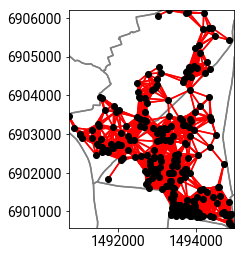

In [65]:
neighbourhoods.boundary.plot(color='grey')
dbandW.plot(pkow_listings, ax=plt.gca(), edge_kws=dict(color='r'), node_kws=dict(zorder=10))
plt.axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
plt.show()

This model of spatial relationships will guarantee that each observation has at least one neighbor, and will prevent any disconnected subgraphs from existing. 

### KNNW

$K$-nearest neighbor weights are constructed by considering the nearest $k$ points to each observation as neighboring that observation. This is a common way of conceptualizing observations' neighbourhoods in machine learning applications, and it is also common in geographic data science applications. 

In [66]:
KNNW = lp.KNN.from_dataframe(pkow_listings, k=10)

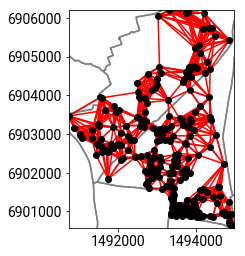

In [67]:
neighbourhoods.boundary.plot(color='grey')
KNNW.plot(pkow_listings,ax=plt.gca(), edge_kws=dict(color='r'), node_kws=dict(zorder=10))
plt.axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
plt.show()

One exceedingly-common method of analysis using KNN weights is by changing `k` repeatedly and finding better values. Thus, the KNN-weights method provides a specific method to do this in a way that avoids re-constructing its core data structure, the `kdtree`. 

Further, this can add additional data to the weights object as well. 

By default, this operates in place, but can also provide a copy of the datastructure if `inplace=False`. 

In [68]:
KNNW20 = KNNW.reweight(k=20, inplace=False)

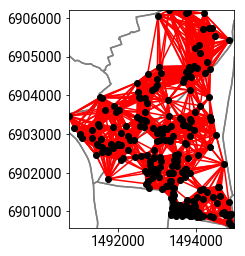

In [69]:
neighbourhoods.boundary.plot(color='grey')
KNNW20.plot(pkow_listings,ax=plt.gca(), edge_kws=dict(color='r'), node_kws=dict(zorder=10))
plt.axis(pkow_listings.total_bounds[np.asarray([0,2,1,3])])
plt.show()

Further, since KNN weights are asymmetric, special methods are provided to make them symmetric:

In [70]:
KNNW20sym = KNNW20.symmetrize()

In [71]:
(KNNW20sym.sparse != KNNW20sym.sparse.T).sum()

0

In [72]:
(KNNW20.sparse != KNNW20.sparse.T).sum()

1972

In fact, these symmetrizing methods exist for any other wieghts type too, so if you've got an arbitrarily-computed weights matrix, it can be used in that case. 

### KNN on Polygons

While K-nearest neighbors weighting methods often make more sense for data in point formats, it's also applicable to data in polygons, were a *representative point* for each polygon is used to construct K-nearest neighbors, instead of the polygons as a whole. 


For comparison, I'll show this alongside of the Queen weights shown above for neighbourhoods in Berlin. 

When the number of nearest neighbours is relatively large compared to the usual cardinality in an adjacency graph, this results in some neighbourhoods being connected to one another more than a single-neigbourhood deep. That is, neighbourhoods are considered spatially connected even if they don't touch, since their *representative points* are so close to one another relative to the nearest alternatives. 

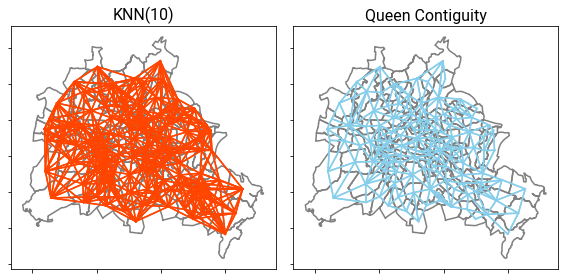

In [73]:
KNN_neighbourhoods = lp.KNN.from_dataframe(neighbourhoods, k=10).symmetrize()

f,ax = plt.subplots(1,2,figsize=(8,4))
for i in range(2):
    neighbourhoods.boundary.plot(color='grey',ax=ax[i])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
KNN_neighbourhoods.plot(neighbourhoods, ax=ax[0], node_kws=dict(s=0), color='orangered')
Qconnected.plot(neighbourhoods, ax=ax[1], node_kws=dict(s=0), color='skyblue')
ax[0].set_title("KNN(10)", fontsize=16)
ax[1].set_title("Queen Contiguity", fontsize=16)
f.tight_layout()
plt.show()

In conrast, very sparse K-nearest neighbours graphs will result in significantly different connectivity structure than the contiguity graph, since the relative position of large areas' *representative points* matters significantly for which observations it touches will be considered "connected." Further, this often reduces the density of areas in the map with small elementary units, where cardinality is often higher. 

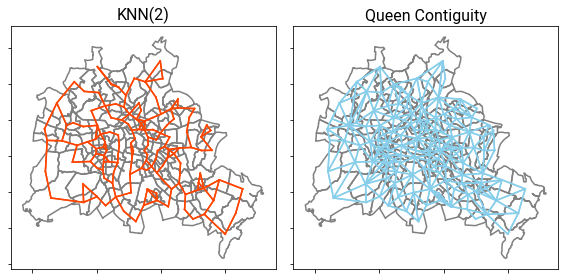

In [74]:
KNN_neighbourhoods = lp.KNN.from_dataframe(neighbourhoods, k=2).symmetrize()

f,ax = plt.subplots(1,2,figsize=(8,4))
for i in range(2):
    neighbourhoods.boundary.plot(color='grey',ax=ax[i])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
KNN_neighbourhoods.plot(neighbourhoods, ax=ax[0], node_kws=dict(s=0), color='orangered')
Qconnected.plot(neighbourhoods, ax=ax[1], node_kws=dict(s=0), color='skyblue')
ax[0].set_title("KNN(2)", fontsize=16)
ax[1].set_title("Queen Contiguity", fontsize=16)
f.tight_layout()
plt.show()

## More representations

There are similarly more representations available and currently under development, such as a networkx interface in `W.to_networkx/W.from_networkx`. Further, we're always willing to add additional constructors or methods to provide new and interesting ways to represent geographic relationships. 

In [75]:
lp.WSP?

Init signature: lp.WSP(sparse, id_order=None)
Docstring:     
Thin W class for spreg.

Parameters
----------

sparse   : sparse_matrix
           NxN object from scipy.sparse

id_order : list
           An ordered list of ids, assumed to match the ordering in
           sparse.

Attributes
----------

n           : int
              description
s0          : float
              description
trcWtW_WW   : float
              description

Examples
--------

From GAL information

>>> import scipy.sparse
>>> import libpysal.api as ps
>>> rows = [0, 1, 1, 2, 2, 3]
>>> cols = [1, 0, 2, 1, 3, 3]
>>> weights =  [1, 0.75, 0.25, 0.9, 0.1, 1]
>>> sparse = scipy.sparse.csr_matrix((weights, (rows, cols)), shape=(4,4))
>>> w = ps.WSP(sparse)
>>> w.s0
4.0
>>> w.trcWtW_WW
6.3949999999999996
>>> w.n
4
File:           ~/anaconda/envs/gds/lib/python3.6/site-packages/libpysal/weights/weights.py
Type:           type
